In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.metrics import mean_absolute_error

sns.set_style('whitegrid')

In [143]:
train_targets = pd.read_parquet('data/A/parquet/train_targets.parquet', engine='pyarrow')
x_test_estimated = pd.read_parquet('data/A/parquet/X_test_estimated.parquet', engine='pyarrow')
x_train_estimated = pd.read_parquet('data/A/parquet/X_train_estimated.parquet', engine='pyarrow')
x_train_observed = pd.read_parquet('data/A/parquet/X_train_observed.parquet', engine='pyarrow')

# merge x_train_observed and x_train_estimated and remove the first column in x_train_estimated
x_train = pd.concat([x_train_observed, x_train_estimated.iloc[:, 1:]], axis=0)

# Set indicies to Datetime
x_train.set_index('date_forecast', inplace=True)
train_targets.set_index('time', inplace=True)

In [144]:
# Create features of train_targets
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    return df

x_train = create_features(x_train)
train_targets = create_features(train_targets)

# x_train doesn't have the column 'pv_measurement' from train_targets, so we need to add it to x_train in the same order as train_targets
x_train['pv_measurement'] = train_targets['pv_measurement']

In [146]:
# Create features and targets
FEATURES = list(x_train.columns)
TARGET = ['pv_measurement']

X_train = x_train[FEATURES]
y_train = train_targets[TARGET]

# Remove rows with NaNs
X_train.dropna(inplace=True)
y_train.dropna(inplace=True)


/tmp/ipykernel_6530/737373615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.dropna(inplace=True)


In [147]:
# reg = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight)
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1)

# Create features and targets, but don't use the column 'pv_measurement' from train_targets
FEATURES = list(x_train.columns)
FEATURES.remove('pv_measurement')

TARGET = ['pv_measurement']

X_train = x_train[FEATURES]
y_train = train_targets[TARGET]

# Remove rows with missing values in y_train
y_train = y_train.dropna()

# Make sure the number of rows in X_train and y_train match
X_train = X_train.iloc[:len(y_train), :]

# Fit the model
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

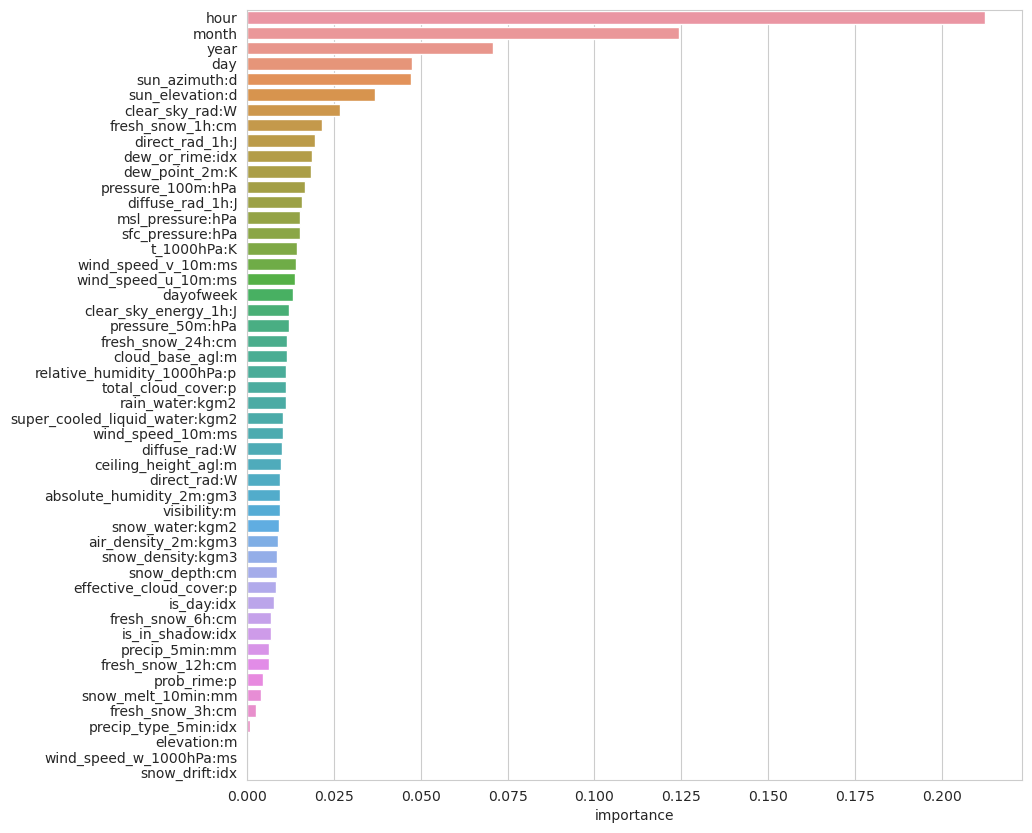

In [148]:
# Plot which features are the most important with sns. Let the features be on the y-axis and the importance on the x-axis
feature_importances = pd.DataFrame(reg.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Create more space between the labels on the y-axis
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.show()
# feature_importances.head()


In [149]:
x_test_estimated = pd.read_parquet('data/A/parquet/X_test_estimated.parquet', engine='pyarrow')

# Set indicies to Datetime
x_test_estimated['date_forecast'] = pd.to_datetime(x_test_estimated['date_forecast'])
x_test_estimated.set_index('date_forecast', inplace=True)

# Create features of x_test_estimated
x_test = create_features(x_test_estimated)

if 'date_calc' in x_test.columns:
    x_test.drop('date_calc', axis=1, inplace=True)

In [150]:
# Predict the values of X_test
y_pred = reg.predict(x_test)

# Store predictions in a DataFrame
predictions = pd.DataFrame({'date_forecast': x_test.index, 'pv_measurement_predicted': y_pred})
predictions.set_index('date_forecast', inplace=True)

# Filter predictions to the desired time period
start_date = '2023-05-01 00:00:00'
end_date = '2023-07-03 23:45:00'
predictions = predictions[start_date:end_date]

# # Set negative values to 0
predictions[predictions < 0] = 0

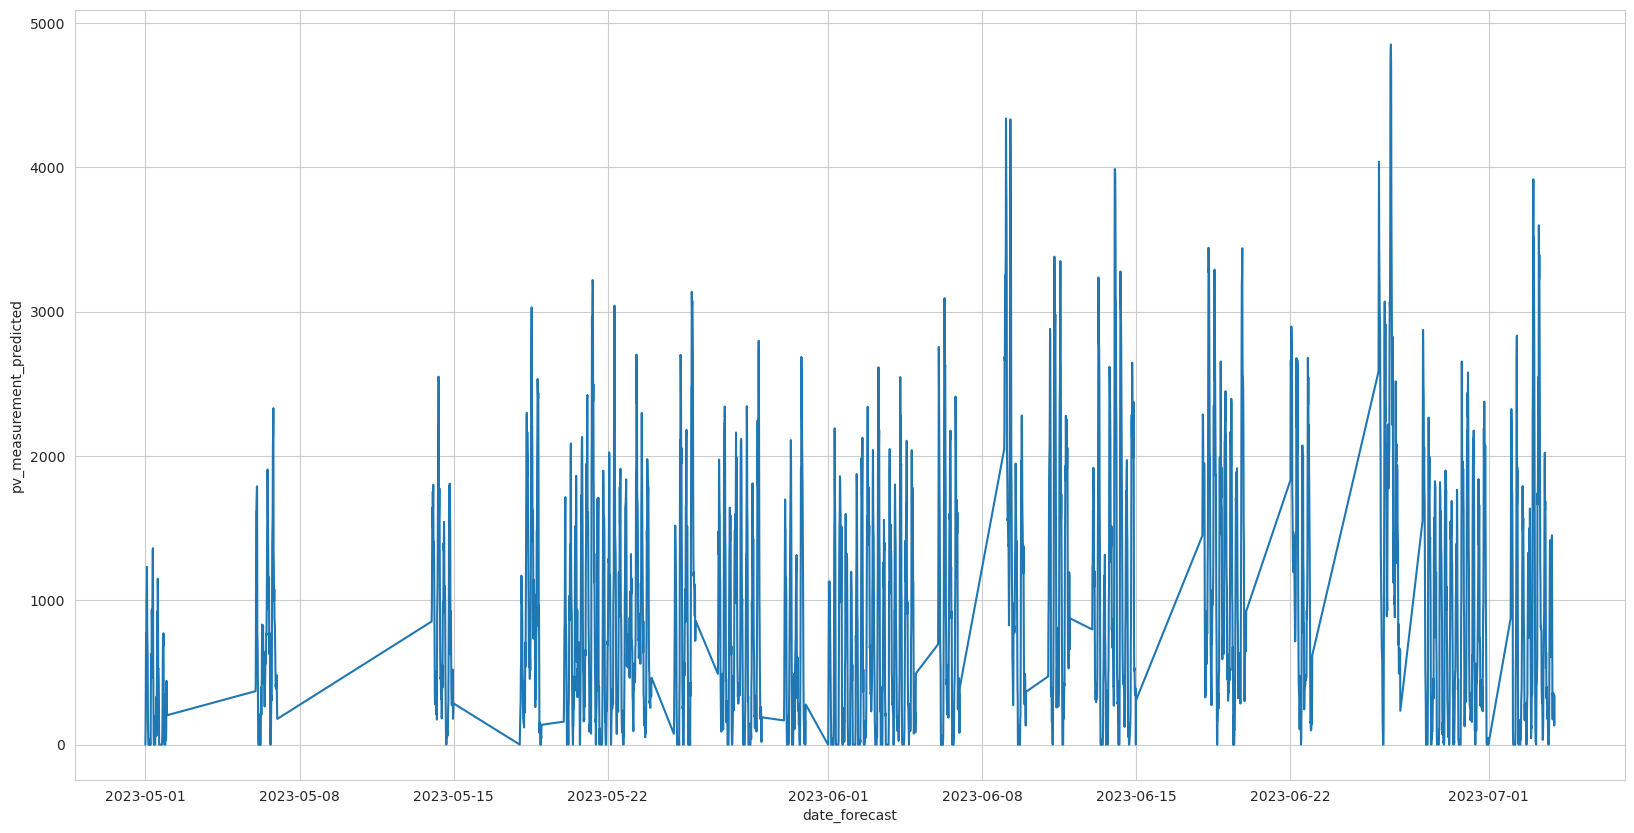

In [151]:
# Plot the predictions
plt.figure(figsize=(20, 10))
sns.lineplot(x=predictions.index, y='pv_measurement_predicted', data=predictions)
plt.show()